# Train UNET

In [1]:
!pip install opencv-python-headless scikit-learn

In [2]:
from PIL import Image
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from diffusers import UNet2DModel
from torchvision import transforms

from sklearn.metrics import precision_recall_curve, auc

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# The model is copied from previous_work/models/unet/UNet.py
class UNetDoubleConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()
        self.double_conv_block = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.double_conv_block(x)


class UNetDownwardLayer(torch.nn.Module):
    def __init__(self, *, in_channels, out_channels) -> None:
        super().__init__()
        self.conv_block = UNetDoubleConvBlock(
            in_channels=in_channels,
            out_channels=out_channels,
        )
        self.down_sample = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        out_forward = self.conv_block(x)
        out_downward = self.down_sample(out_forward)
        return out_forward, out_downward


class UNetUpwardLayer(torch.nn.Module):
    def __init__(self, *, num_features) -> None:
        super().__init__()
        self.conv_block = UNetDoubleConvBlock(
            in_channels=num_features * 2,
            out_channels=num_features,
        )
        self.up_sample_conv = nn.ConvTranspose2d(
            in_channels=num_features * 2,
            out_channels=num_features,
            kernel_size=2,
            stride=2,
        )

    def forward(self, x_from_lower_layer, x_from_encoder_forward):
        x_upsampled = self.up_sample_conv(x_from_lower_layer)
        x = torch.cat(
            (x_upsampled, x_from_encoder_forward),
            dim=1,
        )
        return self.conv_block(x)


class UNet(torch.nn.Module):
    def __init__(
        self, *, in_size=(256, 256), in_channels=1, out_channels=1, init_features=64
    ) -> None:
        super().__init__()
        self.encode_down_layer1 = UNetDownwardLayer(
            in_channels=in_channels,
            out_channels=init_features,
        )
        self.encode_down_layer2 = UNetDownwardLayer(
            in_channels=init_features,
            out_channels=init_features * 2,
        )
        self.encode_down_layer3 = UNetDownwardLayer(
            in_channels=init_features * 2,
            out_channels=init_features * 4,
        )
        self.encode_down_layer4 = UNetDownwardLayer(
            in_channels=init_features * 4,
            out_channels=init_features * 8,
        )
        self.bottom_layer = UNetDoubleConvBlock(
            in_channels=init_features * 8,
            out_channels=init_features * 16,
        )
        self.decode_up_layer4 = UNetUpwardLayer(num_features=init_features * 8)
        self.decode_up_layer3 = UNetUpwardLayer(num_features=init_features * 4)
        self.decode_up_layer2 = UNetUpwardLayer(num_features=init_features * 2)
        self.decode_up_layer1 = UNetUpwardLayer(num_features=init_features)
        self.output_conv = nn.Conv2d(
            in_channels=init_features,
            out_channels=out_channels,
            kernel_size=1,
        )

        self.out_channels = out_channels
        if out_channels == 1:
            self.out_layer_func = nn.Sigmoid()
        else:
            self.out_layer_func = nn.Identity()

    def forward(self, x):
        x_encode_forward1, x_encode_downward1 = self.encode_down_layer1(x)
        x_encode_forward2, x_encode_downward2 = self.encode_down_layer2(
            x_encode_downward1
        )
        x_encode_forward3, x_encode_downward3 = self.encode_down_layer3(
            x_encode_downward2
        )
        x_encode_forward4, x_encode_downward4 = self.encode_down_layer4(
            x_encode_downward3
        )
        x_out_bottom = self.bottom_layer(x_encode_downward4)
        x_decode_upward4 = self.decode_up_layer4(x_out_bottom, x_encode_forward4)
        x_decode_upward3 = self.decode_up_layer3(x_decode_upward4, x_encode_forward3)
        x_decode_upward2 = self.decode_up_layer2(x_decode_upward3, x_encode_forward2)
        x_out_decode = self.decode_up_layer1(x_decode_upward2, x_encode_forward1)
        x_out_result = self.out_layer_func(self.output_conv(x_out_decode))
        return x_out_result

In [4]:
class SegmentedImageDataset(Dataset):
    def __init__(self, img_dir, seg_dir, transform=None):
        self.img_dir = img_dir
        self.seg_dir = seg_dir
        self.transform = transform
        self.filenames = os.listdir(img_dir)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.filenames[idx])
        seg_path = os.path.join(self.seg_dir, self.filenames[idx])
        # Open images as grayscale images -> L
        image = Image.open(img_path).convert("L")
        seg_image = Image.open(seg_path).convert("L")

        if self.transform:
            image = self.transform(image)
            seg_image = self.transform(seg_image)

        return image, seg_image

In [5]:
# Create a Dataset & DataLoader
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor()
])

base_path = "./dentex_dataset/segmentation/enumeration32"
segmentation_folder = os.path.join(base_path, "segmented_images")
image_folder = os.path.join(base_path, "xrays")

dataset = SegmentedImageDataset(image_folder, segmentation_folder, transform)



# Calculate the lengths of train and test sets
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = total_size - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for train and test sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [6]:
# Initialize the UNet2DModel
lr = 0.001

model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [7]:
def train_and_save(model, train_dataloader, val_dataloader, optimizer, num_epochs=10, patience=2, save_path='model_checkpoint.pt'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    train_losses = []
    val_losses = []
    train_mAPs = []
    val_mAPs = []
    best_val_mAP = 0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()

        epoch_loss = 0
        APs = []
        
        for images, seg_images in train_dataloader:
            images = images.to(device)
            seg_images = seg_images.to(device)

            outputs = model(images)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, seg_images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            output_np = outputs.detach().cpu().numpy()
            seg_images_np = seg_images.detach().cpu().numpy()
            seg_images_np = (seg_images_np > 0.5).astype(int)

            precision, recall, _ = precision_recall_curve(seg_images_np.flatten(), output_np.flatten())
            AP = auc(recall, precision)
            APs.append(AP)

        epoch_loss /= len(train_dataloader)
        train_losses.append(epoch_loss)

        train_mAP = sum(APs) / len(APs)
        train_mAPs.append(train_mAP)

        # Validation
        val_loss = 0
        val_APs = []
        model.eval()
        with torch.no_grad():
            for images, seg_images in val_dataloader:
                images = images.to(device)
                seg_images = seg_images.to(device)

                outputs = model(images)
                loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, seg_images)
                val_loss += loss.item()

                output_np = outputs.detach().cpu().numpy()
                seg_images_np = seg_images.detach().cpu().numpy()
                seg_images_np = (seg_images_np > 0.5).astype(int)

                precision, recall, _ = precision_recall_curve(seg_images_np.flatten(), output_np.flatten())
                val_AP = auc(recall, precision)
                val_APs.append(val_AP)

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        val_mAP = sum(val_APs) / len(val_APs)
        val_mAPs.append(val_mAP)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Train mAP: {train_mAP:.4f}, Val mAP: {val_mAP:.4f}')

        # Early stopping
        if epoch > 0 and val_mAPs[-1] > val_mAP:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print('Early stopping!')
                return train_losses, train_mAPs, val_losses, val_mAPs
        else:
            epochs_no_improve = 0
            if val_mAP > best_val_mAP:
                best_val_mAP = val_mAP
                torch.save(model.state_dict(), f'UNET_{save_path}_best.pt')
    return train_losses, train_mAPs, val_losses, val_mAPs

In [8]:
train_losses, train_mAPs, val_losses, val_mAPs = train_and_save(model, train_dataloader, val_dataloader, optimizer, num_epochs=30, save_path='model_checkpoint')

Epoch [1/30], Loss: 0.8622, Val Loss: 0.8637, Train mAP: 0.1616, Val mAP: 0.0836
Epoch [2/30], Loss: 0.8034, Val Loss: 0.9424, Train mAP: 0.3799, Val mAP: 0.1905
Epoch [3/30], Loss: 0.7762, Val Loss: 0.8223, Train mAP: 0.5140, Val mAP: 0.3882
Epoch [4/30], Loss: 0.7570, Val Loss: 0.7564, Train mAP: 0.5666, Val mAP: 0.5885
Epoch [5/30], Loss: 0.7420, Val Loss: 0.7410, Train mAP: 0.6300, Val mAP: 0.6465
Epoch [6/30], Loss: 0.7312, Val Loss: 0.7337, Train mAP: 0.6701, Val mAP: 0.6708
Epoch [7/30], Loss: 0.7237, Val Loss: 0.7221, Train mAP: 0.6796, Val mAP: 0.6648
Epoch [8/30], Loss: 0.7182, Val Loss: 0.7175, Train mAP: 0.6852, Val mAP: 0.6842
Epoch [9/30], Loss: 0.7139, Val Loss: 0.7141, Train mAP: 0.6940, Val mAP: 0.7021
Epoch [10/30], Loss: 0.7107, Val Loss: 0.7108, Train mAP: 0.7020, Val mAP: 0.6849
Epoch [11/30], Loss: 0.7081, Val Loss: 0.7079, Train mAP: 0.7053, Val mAP: 0.6909
Epoch [12/30], Loss: 0.7061, Val Loss: 0.7064, Train mAP: 0.7069, Val mAP: 0.7085
Epoch [13/30], Loss: 0.70

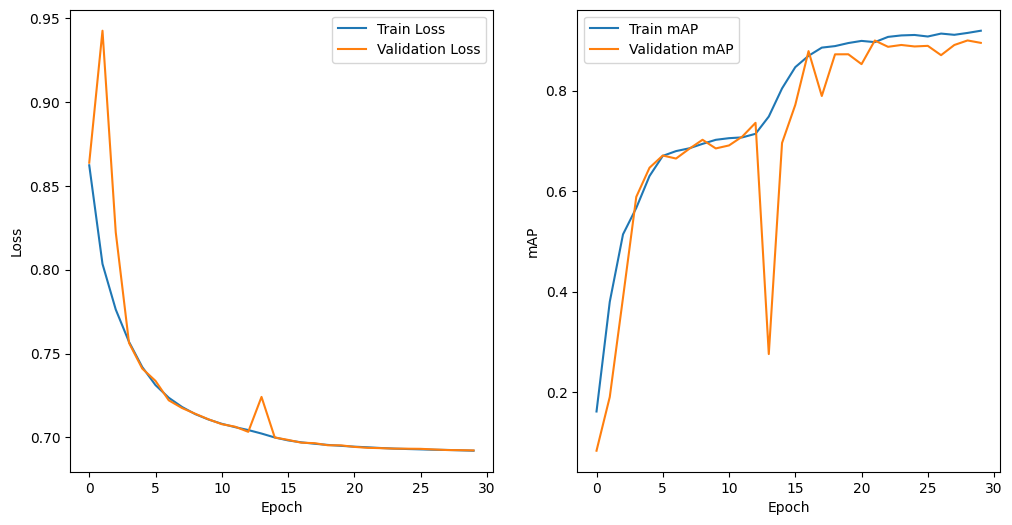

In [9]:
plt.figure(figsize=(12, 6))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting mAPs
plt.subplot(1, 2, 2)
plt.plot(train_mAPs, label='Train mAP')
plt.plot(val_mAPs, label='Validation mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()

plt.show()

In [12]:
!pip install opencv-python-headless

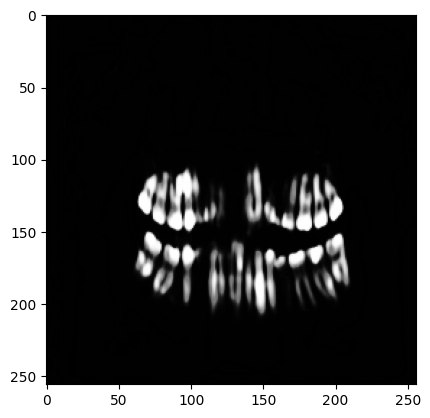

In [13]:
image_path = './dentex_dataset/segmentation/enumeration32/xrays/train_2.png'
image = Image.open(image_path).convert("L")

# Assuming transform is defined somewhere in the code
# Convert the image to PyTorch tensor
image = transform(image)

# Add an extra dimension because the model expects batches
image = image.unsqueeze(0)
image = image.to('cuda')
output = model(image)[0][0]
output_np = output.detach().cpu().numpy()
output_np = output_np * 255
output_np = output_np.astype('uint8')

# Display the output using cv2
plt.imshow(output_np, cmap='gray')